# Multiscale HRV Analysis using DMA and CNN

This notebook implements a multiscale heart rate variability (HRV)
analysis framework using detrended moving average (DMA) curves
and a 1D convolutional neural network (CNN).

Datasets:
- MIT-BIH Normal Sinus Rhythm Database (Healthy)
- BIDMC Congestive Heart Failure Database (CHF)

In [3]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


## Dowloads data from the internet

In [9]:
wfdb.dl_database('nsrdb', dl_dir='../data/nsrdb')
wfdb.dl_database('chfdb', dl_dir='../data/chfdb')


Generating record list for: 16265
Generating record list for: 16272
Generating record list for: 16273
Generating record list for: 16420
Generating record list for: 16483
Generating record list for: 16539
Generating record list for: 16773
Generating record list for: 16786
Generating record list for: 16795
Generating record list for: 17052
Generating record list for: 17453
Generating record list for: 18177
Generating record list for: 18184
Generating record list for: 19088
Generating record list for: 19090
Generating record list for: 19093
Generating record list for: 19140
Generating record list for: 19830
Generating list of all files for: 16265
Generating list of all files for: 16272
Generating list of all files for: 16273
Generating list of all files for: 16420
Generating list of all files for: 16483
Generating list of all files for: 16539
Generating list of all files for: 16773
Generating list of all files for: 16786
Generating list of all files for: 16795
Generating list of all files

## Load & Visualize One ECG Record (Code Cell)

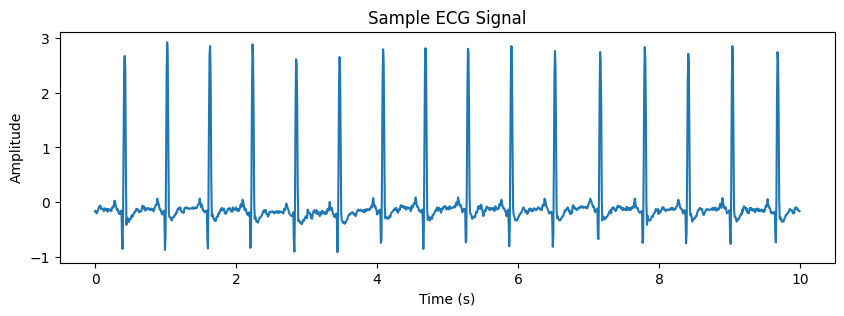

In [10]:
record = wfdb.rdrecord('../data/nsrdb/16265')
annotation = wfdb.rdann('../data/nsrdb/16265', 'atr')

fs = record.fs
signal = record.p_signal[:,0]

time = np.arange(len(signal)) / fs

plt.figure(figsize=(10,3))
plt.plot(time[:10*fs], signal[:10*fs])
plt.title("Sample ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


## Extract RR Intervals (Code Cell)-raw RR intervals

In [12]:
r_peaks = annotation.sample
rr_intervals = np.diff(r_peaks) / fs * 1000


## RR Interval Cleaning Functions -(These are reusable utilities.)

In [14]:
def clean_rr(rr):
    return rr[(rr > 300) & (rr < 1600)]

def remove_sudden_changes(rr):
    clean = [rr[0]]
    for i in range(1, len(rr)):
        if abs(rr[i] - clean[-1]) / clean[-1] < 0.2:
            clean.append(rr[i])
    return np.array(clean)

def interpolate_rr(rr):
    x = np.arange(len(rr))
    f = interp1d(x, rr, kind='linear', fill_value="extrapolate")
    return f(x)


## Clean RR Intervals-NN intervals

In [15]:
rr_clean = clean_rr(rr_intervals)
rr_clean = remove_sudden_changes(rr_clean)
rr_clean = interpolate_rr(rr_clean)


## RR Segmentation Function

In [16]:
def segment_rr(rr, window_size=7200, overlap=0.75):
    step = int(window_size * (1 - overlap))
    segments = []
    for start in range(0, len(rr) - window_size, step):
        segments.append(rr[start:start+window_size])
    return segments


## Segment RR Signal-Confirms segmentation

In [17]:
rr_segments = segment_rr(rr_clean)
len(rr_segments)


47

## DMA Computation Function

In [18]:
def compute_dma(rr, scales):
    rr = rr - np.mean(rr)
    F = []

    for s in scales:
        ma = np.convolve(rr, np.ones(s)/s, mode='valid')
        detrended = rr[:len(ma)] - ma
        F.append(np.sqrt(np.mean(detrended**2)))

    return np.array(F)


## DMA Scales + Plot

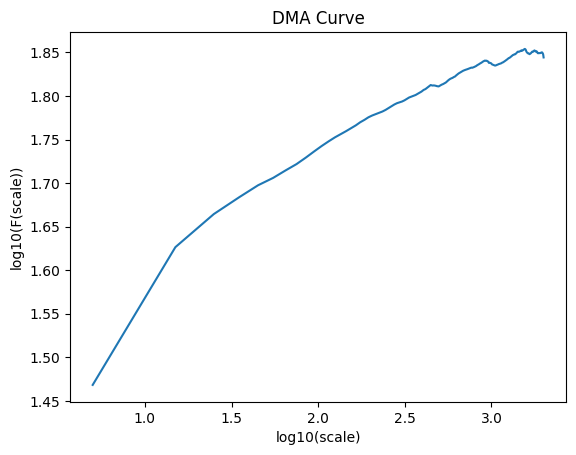

In [19]:
scales = np.linspace(5, 2000, 200).astype(int)
dma_curve = compute_dma(rr_segments[0], scales)

plt.plot(np.log10(scales), np.log10(dma_curve))
plt.xlabel("log10(scale)")
plt.ylabel("log10(F(scale))")
plt.title("DMA Curve")
plt.show()


## Build Dataset

In [20]:
X, y = [], []

for seg in rr_segments:
    X.append(compute_dma(seg, scales))
    y.append(0)  # healthy


## Prepare CNN Input

In [21]:
X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)


## CNN Model

In [22]:
model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(200,1)),
    Conv1D(64, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


/Users/surbhitiwari/Desktop/MajorProject/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train Model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 451ms/step - accuracy: 1.0000 - loss: 4.4852e-07 - val_accuracy: 1.0000 - val_loss: 1.7930e-10
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 6.7924e-09 - val_accuracy: 1.0000 - val_loss: 7.5427e-12
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.1963e-10 - val_accuracy: 1.0000 - val_loss: 7.9161e-13
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 8.0222e-11 - val_accuracy: 1.0000 - val_loss: 1.4123e-13
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.3717e-11 - val_accuracy: 1.0000 - val_loss: 3.6180e-14
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.0452e-11 - val_accuracy: 1.0000 - val_loss: 1.2126e-14
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 4.5665e-12 - val_accuracy: 1.0000 - val_loss: 5.0898e-15
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 

## Evaluate Model

In [24]:
y_pred = model.predict(X_test).ravel()
y_label = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_label))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Accuracy: 1.0
ROC AUC: nan


/Users/surbhitiwari/Desktop/MajorProject/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
